In [40]:
import bioframe as bf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pathlib import Path
import seaborn as sns
from tqdm import tqdm
from scipy.stats import spearmanr, mannwhitneyu, fisher_exact
from scipy.special import expit as sigmoid
from sklearn.metrics import roc_auc_score, precision_recall_curve, auc

In [41]:
models = [
    "ConvNet_batch2048_weight1.0_secondpart_30k",
    "ConvNet_batch2048_secondpart_30k",
    "ConvNet_batch2048_weight0_secondpart_30k",
    "vep/scratch/users/gbenegas/checkpoints/GPN_Arabidopsis_multispecies/ConvNet_ss_12k/checkpoint-12000",
    "phyloP",
    "phastCons",
]
model_renaming = {
    #"ConvNet_batch2048_secondpart_30k": "GPN",
    "ConvNet_batch2048_weight1.0_secondpart_30k": "repeat-weight-1",
    "ConvNet_batch2048_secondpart_30k": "repeat-weight-0.1",
    "ConvNet_batch2048_weight0_secondpart_30k": "repeat-weight-0",
    #"ConvNet_batch2048_secondpart_30k": "8 species",
    "vep/scratch/users/gbenegas/checkpoints/GPN_Arabidopsis_multispecies/ConvNet_ss_12k/checkpoint-12000": "1 species",
}

In [42]:
d = Path(f"output/variants/all")
variants = pd.read_parquet(d / "variants.parquet")

for m in models:
    model_path = d / f"{m}.parquet"
    model_name = model_renaming.get(m, m)
    variants[model_name] = pd.read_parquet(model_path)["score"].values
variants

,chrom,pos,ref,alt,AC,AF,consequence,repeat-weight-1,repeat-weight-0.1,repeat-weight-0,1 species,phyloP,phastCons
0,1,266,G,A,82,0.040414,intergenic_variant,-0.176330,-0.670362,-0.445351,-0.251338,0.813899,-0.000523
1,1,270,G,A,16,0.007886,intergenic_variant,-0.379471,-0.406548,-0.420469,-0.344978,0.097275,-0.007196
2,1,276,T,G,16,0.007886,intergenic_variant,-0.385746,-0.643284,-0.389775,0.059943,0.493032,-0.000789
3,1,284,T,A,1,0.000493,intergenic_variant,-0.944210,-0.779196,-0.816459,-0.729820,0.703100,-0.000292
4,1,286,T,A,1,0.000493,intergenic_variant,0.029241,-0.048531,0.058114,-0.465444,1.644564,-0.000070
...,...,...,...,...,...,...,...,...,...,...,...,...,...
10697059,5,26975233,C,G,1,0.000493,intergenic_variant,-5.337580,-4.791409,-5.198257,-0.808084,-0.773075,-0.285819
10697060,5,26975235,G,A,11,0.005421,intergenic_variant,-2.259923,-1.822485,-2.670869,0.744265,-0.267246,-0.259101
10697061,5,26975240,C,T,4,0.001971,intergenic_variant,-3.595089,-3.438794,-3.626871,-0.797683,-0.764734,-0.229109
10697062,5,26975245,G,A,7,0.003450,intergenic_variant,-2.704678,-2.521554,-3.239656,-0.278273,-0.862251,-0.094685


In [43]:
variants["phyloP-abs"] = -variants["phyloP"].abs()
models.append("phyloP-abs")

In [44]:
variants.consequence = variants.consequence.str.replace("_variant", "")
variants

,chrom,pos,ref,alt,AC,AF,consequence,repeat-weight-1,repeat-weight-0.1,repeat-weight-0,1 species,phyloP,phastCons,phyloP-abs
0,1,266,G,A,82,0.040414,intergenic,-0.176330,-0.670362,-0.445351,-0.251338,0.813899,-0.000523,-0.813899
1,1,270,G,A,16,0.007886,intergenic,-0.379471,-0.406548,-0.420469,-0.344978,0.097275,-0.007196,-0.097275
2,1,276,T,G,16,0.007886,intergenic,-0.385746,-0.643284,-0.389775,0.059943,0.493032,-0.000789,-0.493032
3,1,284,T,A,1,0.000493,intergenic,-0.944210,-0.779196,-0.816459,-0.729820,0.703100,-0.000292,-0.703100
4,1,286,T,A,1,0.000493,intergenic,0.029241,-0.048531,0.058114,-0.465444,1.644564,-0.000070,-1.644564
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10697059,5,26975233,C,G,1,0.000493,intergenic,-5.337580,-4.791409,-5.198257,-0.808084,-0.773075,-0.285819,-0.773075
10697060,5,26975235,G,A,11,0.005421,intergenic,-2.259923,-1.822485,-2.670869,0.744265,-0.267246,-0.259101,-0.267246
10697061,5,26975240,C,T,4,0.001971,intergenic,-3.595089,-3.438794,-3.626871,-0.797683,-0.764734,-0.229109,-0.764734
10697062,5,26975245,G,A,7,0.003450,intergenic,-2.704678,-2.521554,-3.239656,-0.278273,-0.862251,-0.094685,-0.862251


In [45]:
models = [model_renaming.get(m, m) for m in models]
models

['repeat-weight-1',
 'repeat-weight-0.1',
 'repeat-weight-0',
 '1 species',
 'phyloP',
 'phastCons',
 'phyloP-abs']

In [46]:
variants = variants.query("AF < 0.5")
variants

,chrom,pos,ref,alt,AC,AF,consequence,repeat-weight-1,repeat-weight-0.1,repeat-weight-0,1 species,phyloP,phastCons,phyloP-abs
0,1,266,G,A,82,0.040414,intergenic,-0.176330,-0.670362,-0.445351,-0.251338,0.813899,-0.000523,-0.813899
1,1,270,G,A,16,0.007886,intergenic,-0.379471,-0.406548,-0.420469,-0.344978,0.097275,-0.007196,-0.097275
2,1,276,T,G,16,0.007886,intergenic,-0.385746,-0.643284,-0.389775,0.059943,0.493032,-0.000789,-0.493032
3,1,284,T,A,1,0.000493,intergenic,-0.944210,-0.779196,-0.816459,-0.729820,0.703100,-0.000292,-0.703100
4,1,286,T,A,1,0.000493,intergenic,0.029241,-0.048531,0.058114,-0.465444,1.644564,-0.000070,-1.644564
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10697059,5,26975233,C,G,1,0.000493,intergenic,-5.337580,-4.791409,-5.198257,-0.808084,-0.773075,-0.285819,-0.773075
10697060,5,26975235,G,A,11,0.005421,intergenic,-2.259923,-1.822485,-2.670869,0.744265,-0.267246,-0.259101,-0.267246
10697061,5,26975240,C,T,4,0.001971,intergenic,-3.595089,-3.438794,-3.626871,-0.797683,-0.764734,-0.229109,-0.764734
10697062,5,26975245,G,A,7,0.003450,intergenic,-2.704678,-2.521554,-3.239656,-0.278273,-0.862251,-0.094685,-0.862251


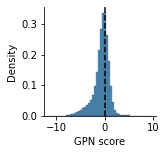

In [9]:
plt.figure(figsize=(2,2))
sns.histplot(
    data=variants,
    x="GPN",
    bins=50,
    stat="density",
)
plt.axvline(0, linestyle="--", color="black")
plt.xlabel("GPN score")
sns.despine();
#plt.savefig("output/plots/gpn_score_hist.svg", bbox_inches="tight")

/tmp/ipykernel_3897213/1240158466.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  variants["bin"] = pd.cut(variants.GPN, bins)
/tmp/ipykernel_3897213/1240158466.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  variants["bin_midpoint"] = variants.bin.apply(lambda x: x.mid)


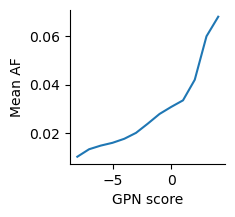

In [8]:
#bins = np.linspace(-8, 5)
bins = np.arange(-8.5, 5.5)
variants["bin"] = pd.cut(variants.GPN, bins)
variants["bin_midpoint"] = variants.bin.apply(lambda x: x.mid)
plt.figure(figsize=(2,2))
g = sns.lineplot(
    data=variants,
    x="bin_midpoint",
    y="AF",
    errorbar=None,
)
plt.xlabel("GPN score")
plt.ylabel("Mean AF")
sns.despine();
#plt.savefig("output/plots/gpn_score_vs_af.svg", bbox_inches="tight")

/tmp/ipykernel_3897213/1127134688.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  variants["GPN score"] = variants.bin


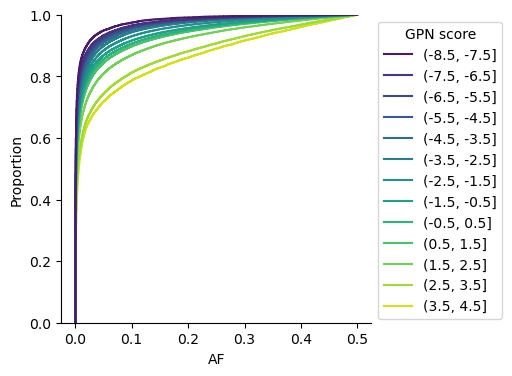

In [9]:
variants["GPN score"] = variants.bin
plt.figure(figsize=(4,4))
g = sns.ecdfplot(
    data=variants,#df[df["GPN score percentile bin"].isin([1, 50, 100])],
    hue="GPN score",
    x="AF",
    palette="viridis",
    #stat="probability",
    #bins=10,
    #multiple="dodge",
)
sns.move_legend(g, "upper left", bbox_to_anchor=(1, 1))
sns.despine()
#plt.savefig("output/plots/gpn_score_vs_af_cdf.pdf", bbox_inches="tight")

In [47]:
repeats = pd.read_csv("input/repeats.bed.gz", sep="\t").rename(columns=dict(genoName="chrom", genoStart="start", genoEnd="end"))
repeats.chrom = repeats.chrom.str.replace("Chr", "")
repeats

,#bin,swScore,milliDiv,milliDel,milliIns,chrom,start,end,genoLeft,strand,repName,repClass,repFamily,repStart,repEnd,repLeft,id
0,10,444,191,54,76,1,12582773,12582920,-17844751,-,Helitron1,RC,Helitron,-9953,5856,5713,5
1,10,6899,30,0,1,1,13630758,13631561,-16796110,-,ATENSPM2,DNA,CMC-EnSpm,-6268,1985,1184,6
2,10,2521,72,3,2,1,14676131,14685672,-15741999,-,AR3,Satellite,Satellite,-73,9553,1,6
3,10,6227,45,48,6,1,15728234,15729041,-14698630,+,ATCopia95LTR,LTR,Copia,1,841,0,8
4,11,537,291,44,131,1,18873944,18874466,-11553205,-,Atlantys3_LTR,LTR,Gypsy,-12,482,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
69340,587,238,156,0,0,M,361356,361401,-5523,-,SSU-rRNA_Ath,rRNA,rRNA,-16,1886,1842,6
69341,587,278,263,0,0,M,361523,361599,-5325,-,SSU-rRNA_Ath,rRNA,rRNA,-164,1738,1663,6
69342,587,582,289,31,44,M,362179,362407,-4517,-,SSU-rRNA_Ath,rRNA,rRNA,-481,1421,1197,6
69343,587,336,258,62,42,M,364854,365016,-1908,+,LSU-rRNA_Ath,rRNA,rRNA,797,961,-2414,6


In [48]:
variants["start"] = variants.pos
variants["end"] = variants.start + 1
variants = bf.coverage(variants, repeats).rename(columns={"coverage": "repeat"})
variants.repeat = variants.repeat.astype(bool)
variants

/tmp/ipykernel_3867070/3514059738.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  variants["start"] = variants.pos
/tmp/ipykernel_3867070/3514059738.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  variants["end"] = variants.start + 1


,chrom,pos,ref,alt,AC,AF,consequence,repeat-weight-1,repeat-weight-0.1,repeat-weight-0,1 species,phyloP,phastCons,phyloP-abs,start,end,repeat
0,1,266,G,A,82,0.040414,intergenic,-0.176330,-0.670362,-0.445351,-0.251338,0.813899,-0.000523,-0.813899,266,267,False
1,1,270,G,A,16,0.007886,intergenic,-0.379471,-0.406548,-0.420469,-0.344978,0.097275,-0.007196,-0.097275,270,271,False
2,1,276,T,G,16,0.007886,intergenic,-0.385746,-0.643284,-0.389775,0.059943,0.493032,-0.000789,-0.493032,276,277,False
3,1,284,T,A,1,0.000493,intergenic,-0.944210,-0.779196,-0.816459,-0.729820,0.703100,-0.000292,-0.703100,284,285,False
4,1,286,T,A,1,0.000493,intergenic,0.029241,-0.048531,0.058114,-0.465444,1.644564,-0.000070,-1.644564,286,287,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10305055,5,26975233,C,G,1,0.000493,intergenic,-5.337580,-4.791409,-5.198257,-0.808084,-0.773075,-0.285819,-0.773075,26975233,26975234,False
10305056,5,26975235,G,A,11,0.005421,intergenic,-2.259923,-1.822485,-2.670869,0.744265,-0.267246,-0.259101,-0.267246,26975235,26975236,False
10305057,5,26975240,C,T,4,0.001971,intergenic,-3.595089,-3.438794,-3.626871,-0.797683,-0.764734,-0.229109,-0.764734,26975240,26975241,False
10305058,5,26975245,G,A,7,0.003450,intergenic,-2.704678,-2.521554,-3.239656,-0.278273,-0.862251,-0.094685,-0.862251,26975245,26975246,False


In [49]:
variants.repeat.value_counts()

repeat
False    7906478
True     2398582
Name: count, dtype: int64

In [50]:
consequences = [
    'all',
    #'repeat',
]
specific_consequences = variants.consequence.value_counts()[:8].index.values.tolist()
#consequences += specific_consequences
consequences

['all']

In [51]:
# conservation scores undefined in unaligned regions
# could additionally evaluate results without conservation scores
variants.dropna(inplace=True)
variants

,chrom,pos,ref,alt,AC,AF,consequence,repeat-weight-1,repeat-weight-0.1,repeat-weight-0,1 species,phyloP,phastCons,phyloP-abs,start,end,repeat
0,1,266,G,A,82,0.040414,intergenic,-0.176330,-0.670362,-0.445351,-0.251338,0.813899,-0.000523,-0.813899,266,267,False
1,1,270,G,A,16,0.007886,intergenic,-0.379471,-0.406548,-0.420469,-0.344978,0.097275,-0.007196,-0.097275,270,271,False
2,1,276,T,G,16,0.007886,intergenic,-0.385746,-0.643284,-0.389775,0.059943,0.493032,-0.000789,-0.493032,276,277,False
3,1,284,T,A,1,0.000493,intergenic,-0.944210,-0.779196,-0.816459,-0.729820,0.703100,-0.000292,-0.703100,284,285,False
4,1,286,T,A,1,0.000493,intergenic,0.029241,-0.048531,0.058114,-0.465444,1.644564,-0.000070,-1.644564,286,287,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10305055,5,26975233,C,G,1,0.000493,intergenic,-5.337580,-4.791409,-5.198257,-0.808084,-0.773075,-0.285819,-0.773075,26975233,26975234,False
10305056,5,26975235,G,A,11,0.005421,intergenic,-2.259923,-1.822485,-2.670869,0.744265,-0.267246,-0.259101,-0.267246,26975235,26975236,False
10305057,5,26975240,C,T,4,0.001971,intergenic,-3.595089,-3.438794,-3.626871,-0.797683,-0.764734,-0.229109,-0.764734,26975240,26975241,False
10305058,5,26975245,G,A,7,0.003450,intergenic,-2.704678,-2.521554,-3.239656,-0.278273,-0.862251,-0.094685,-0.862251,26975245,26975246,False


In [15]:
from scipy.stats import pearsonr, spearmanr

for model in ["phyloP", "phastCons"]:
    print(model)
    print(pearsonr(variants["GPN"], variants[model]))
    print(spearmanr(variants["GPN"], variants[model]))

phyloP
PearsonRResult(statistic=0.22619744507417752, pvalue=0.0)
SpearmanrResult(correlation=0.1962338480288296, pvalue=0.0)
phastCons
PearsonRResult(statistic=0.1276288054104526, pvalue=0.0)
SpearmanrResult(correlation=0.12637284836269672, pvalue=0.0)


In [52]:
variants["Status"] = "Neither"
variants.loc[variants.AC == 1, "Status"] = "Rare"
variants.loc[variants.AF >= 0.05, "Status"] = "Common"
variants = variants[variants.Status!="Neither"]
variants.Status = variants.Status.astype('category')
variants.Status.value_counts()

/tmp/ipykernel_3867070/867144211.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  variants.Status = variants.Status.astype('category')


Status
Rare      3013655
Common    1254167
Name: count, dtype: int64

In [53]:
from math import sqrt

def compute_odds_ratio(df, threshold_quantile, model_name):
    df = df.copy()
    threshold = df[model_name].quantile(threshold_quantile)
    df.loc[df[model_name] <= threshold, "ModelScoreTier"] = "Low" 
    #df.loc[df[model_name] > df[model_name].quantile(0.1), "ModelScoreTier"] = "High"
    df.loc[df[model_name] > threshold, "ModelScoreTier"] = "High"
    df = df[df.ModelScoreTier.isin(["Low", "High"])]
    
    df.ModelScoreTier = df.ModelScoreTier.astype('category')
    group_counts = df.groupby(["Status", "ModelScoreTier"]).size()
    log_odds_se = sqrt(sum(1/group_counts)) # "All of statistics" eq. 15.7
    group_counts2 = group_counts.copy()
    #print(group_counts2)
    group_counts = group_counts.loc[pd.MultiIndex.from_tuples(
        [['Common', 'High'],
         ['Common', 'Low'],
         ['Rare', 'High'],
         ['Rare', 'Low']]
    )].values.reshape((2,2))
    min_counts = group_counts.min()
    odds_ratio, p_value = fisher_exact(group_counts, alternative='greater')
    log_odds_ratio = np.log(odds_ratio)
    ci_lower = np.exp(log_odds_ratio-2*log_odds_se)
    ci_upper = np.exp(log_odds_ratio+2*log_odds_se)
    # [ci_lower, ci_upper] is 95% CI
    if np.isinf(odds_ratio):
        print(odds_ratio, p_value, group_counts2)
    return odds_ratio, p_value, min_counts, ci_lower, ci_upper

In [55]:
def get_subtitle(consequence, n_rare, n_common):
    c = consequence.replace("_variant", "")
    return f"{c}\nn={n_rare} vs. {n_common}"

threshold_quantiles = [
    1e-3,
    1e-2,
    1e-1
]


rows = []
for c in consequences:
    if c == "all":
        df_c = variants.copy()
    elif c == "repeat":
        df_c = variants[variants.repeat]
    else:
        df_c = variants[variants.consequence==c]
    df_c = df_c.dropna(subset=models)
    for m in models:
        subtitle = get_subtitle(c, (df_c.Status=="Rare").sum(), (df_c.Status=="Common").sum())
        for tq in threshold_quantiles:
            print(c, m, tq)
            #if tq == 1e-4 and c != "all": continue
            OR, p_value, min_counts, cil, ciu = compute_odds_ratio(df_c[[m, "Status"]], tq, m)
            rows.append([m, c, tq, OR, p_value, min_counts, cil, ciu, subtitle])
results = pd.DataFrame(rows, columns=["Model", "Consequence", "Threshold quantile", "Odds ratio", "p_value", "min_counts", "cil", "ciu", "subtitle"])
results

all repeat-weight-1 0.001
all repeat-weight-1 0.01
all repeat-weight-1 0.1
all repeat-weight-0.1 0.001
all repeat-weight-0.1 0.01
all repeat-weight-0.1 0.1
all repeat-weight-0 0.001
all repeat-weight-0 0.01
all repeat-weight-0 0.1
all 1 species 0.001
all 1 species 0.01
all 1 species 0.1
all phyloP 0.001
all phyloP 0.01
all phyloP 0.1
all phastCons 0.001
all phastCons 0.01
all phastCons 0.1
all phyloP-abs 0.001
all phyloP-abs 0.01
all phyloP-abs 0.1


,Model,Consequence,Threshold quantile,Odds ratio,p_value,min_counts,cil,ciu,subtitle
0,repeat-weight-1,all,0.001,4.782266,2.511089e-260,342,4.272225,5.353199,all\nn=3013655 vs. 1254167
1,repeat-weight-1,all,0.010,2.856786,0.000000e+00,5465,2.774987,2.940996,all\nn=3013655 vs. 1254167
2,repeat-weight-1,all,0.100,1.782025,0.000000e+00,84204,1.767815,1.796350,all\nn=3013655 vs. 1254167
3,repeat-weight-0.1,all,0.001,5.282335,2.396656e-281,312,4.696141,5.941701,all\nn=3013655 vs. 1254167
4,repeat-weight-0.1,all,0.010,3.074645,0.000000e+00,5126,2.984204,3.167826,all\nn=3013655 vs. 1254167
5,repeat-weight-0.1,all,0.100,1.791774,0.000000e+00,83864,1.777467,1.806197,all\nn=3013655 vs. 1254167
6,repeat-weight-0,all,0.001,5.174773,4.875115e-277,318,4.605238,5.814742,all\nn=3013655 vs. 1254167
7,repeat-weight-0,all,0.010,3.107146,0.000000e+00,5079,3.015392,3.201692,all\nn=3013655 vs. 1254167
8,repeat-weight-0,all,0.100,1.584262,0.000000e+00,91766,1.571991,1.596629,all\nn=3013655 vs. 1254167
9,1 species,all,0.001,2.391484,3.121006e-110,633,2.194054,2.606679,all\nn=3013655 vs. 1254167


In [56]:
results["Odds ratio"].max()  # careful with inf

5.282335010057782

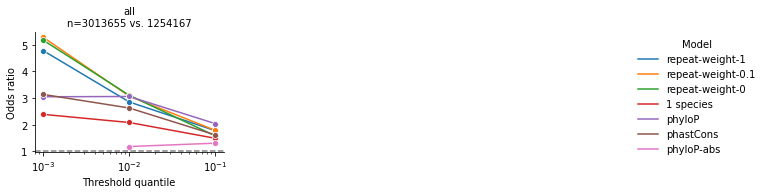

In [57]:
g = sns.relplot(
    data=results[(results.p_value<=0.05)],
    x="Threshold quantile",
    y="Odds ratio",
    hue="Model",
    hue_order=models,
    col="subtitle",
    height=3,
    kind="line",
    marker="o",
    col_wrap=3,
    facet_kws={'sharey': False, 'sharex': True},
)
for ax in g.axes: ax.axhline(1, ls='--', color="grey")
g.set_titles(col_template="{col_name}", row_template="{row_name}")
g.set(xscale='log');
g.fig.subplots_adjust(top=0.75)
#plt.savefig("output/plots/rare_vs_common_line.pdf", bbox_inches='tight')

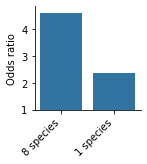

In [19]:
plt.figure(figsize=(1.9,1.9))
g = sns.barplot(
    data=results[(results.p_value<=0.05)&(results["Threshold quantile"]==1e-3)&(results.Consequence=="all")],
    y="Odds ratio",
    x="Model",
    color="C0",
);
g.set(ylim=(1))
sns.despine()
plt.xlabel("");
g.set_xticklabels(g.get_xticklabels(), rotation=45, ha='right');
#plt.savefig("output/plots/rare_vs_common_bar.svg", bbox_inches='tight');
#plt.savefig("output/plots/rare_vs_common_bar_repeat_weight.svg", bbox_inches='tight');
#plt.savefig("output/plots/rare_vs_common_bar_1_vs_0.01.svg", bbox_inches='tight');
#plt.savefig("output/plots/rare_vs_common_bar_5_vs_0.05.svg", bbox_inches='tight');
#plt.savefig("output/plots/rare_vs_common_bar_n_species.svg", bbox_inches='tight');

In [20]:
results[(results.p_value<=0.05) & (results["Threshold quantile"]==1e-3) & (results.Consequence=="all")]

,Model,Consequence,Threshold quantile,Odds ratio,p_value,min_counts,cil,ciu,subtitle
1,repeat-weight-1,all,0.001,4.356719,1.125697e-282,441,3.942886,4.813986,all\nn=3533596 vs. 1418192
5,repeat-weight-0.1,all,0.001,4.598271,4.933793e-296,419,4.151780,5.092779,all\nn=3533596 vs. 1418192
9,repeat-weight-0,all,0.001,4.499943,8.416505e-289,424,4.065225,4.981147,all\nn=3533596 vs. 1418192


In [21]:
results[(results.p_value<=0.05) & (results["Threshold quantile"]==1e-4) & (results.Consequence=="all")]

,Model,Consequence,Threshold quantile,Odds ratio,p_value,min_counts,cil,ciu,subtitle
0,repeat-weight-1,all,0.0001,8.759082,2.871996e-46,23,5.714681,13.425337,all\nn=3533596 vs. 1418192
4,repeat-weight-0.1,all,0.0001,7.683293,1.961721e-43,26,5.135143,11.495881,all\nn=3533596 vs. 1418192
8,repeat-weight-0,all,0.0001,7.938662,7.315525e-44,25,5.265947,11.967905,all\nn=3533596 vs. 1418192
